# Few-shot learning - Omniglot - Fellowship.ai

## Context

#### Fellowship.ai - Few-shot learning
This is my personal project to the few-shot learning challenge from [Fellowship.ai](https://fellowship.ai/challenge/) with the following goal:
> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

#### Omniglot - Dataset
*Dataset reference:* [Link](https://github.com/brendenlake/omniglot)
> Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

The Omniglot dataset is often considered as the transpose of the MNIST dataset. While the latter contains only 10 classes with a training set of 60000 examples, Omniglot contains an important number of classes (1623 different handwritten characters from 50 different alphabets) with only a low number of examples (20) for each, making it an ideal dataset for few-shot learning problems.

#### Few-shot learning
Whereas, lots of deep learning projects are based on a huge number of training examples to be trained, few-shot learning is  based only on a few one. This approach is much closer to the one experienced by humans. We are able to memorize and recognize objects we have never seen before from a few number of examples. Then for each new encounter with these types of object we can classify them in an accurate and easy way.


#### Stategy





## Main Goal

### Import libraries

In [29]:
import os
import glob

import tensorflow as tf
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, concatenate,AveragePooling2D, MaxPooling2D, Dropout, Lambda, Add
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

from sklearn.model_selection import train_test_split

from PIL import Image                                                                                                                               
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
import h5py


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### PATH

We indicate the PATH of the training examples.

In [3]:
#Training images path
PATH="images_background/"

#Validation and test images path
PATH_TEST = "images_evaluation/"

### Exploratory Data Analysis

We have a look at the list of all alphabets contained in the training set, and their total number.

In [4]:
alph_type = np.array(os.listdir(PATH)) #Give the different types of alphabet in our training data
print(f"List of the different alphabets:\n {alph_type}")
print(f"\nNumber of different alphabets: {len(alph_type)}")

List of the different alphabets:
 ['Alphabet_of_the_Magi' 'Anglo-Saxon_Futhorc' 'Arcadian' 'Armenian'
 'Asomtavruli_(Georgian)' 'Balinese' 'Bengali'
 'Blackfoot_(Canadian_Aboriginal_Syllabics)' 'Braille' 'Burmese_(Myanmar)'
 'Cyrillic' 'Early_Aramaic' 'Futurama' 'Grantha' 'Greek' 'Gujarati'
 'Hebrew' 'Inuktitut_(Canadian_Aboriginal_Syllabics)'
 'Japanese_(hiragana)' 'Japanese_(katakana)' 'Korean' 'Latin'
 'Malay_(Jawi_-_Arabic)' 'Mkhedruli_(Georgian)' 'N_Ko'
 'Ojibwe_(Canadian_Aboriginal_Syllabics)' 'Sanskrit' 'Syriac_(Estrangelo)'
 'Tagalog' 'Tifinagh']

Number of different alphabets: 30


We then check the number of character for each alphabets.

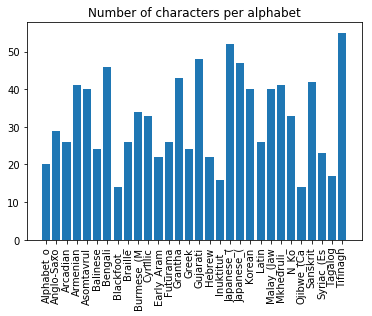


The maximum number of different character for one alphabet is 55
The minimum number of different character for one alphabet is 14
The total number of different character is 964


In [5]:
alph_num_char ={alphabet:len(os.listdir(f'{PATH}{alphabet}')) for alphabet in alph_type}
num_of_char = alph_num_char.values()

plt.bar(range(len(alph_type)),num_of_char)
plt.xticks(range(len(alph_type)), [alph[:10] for alph in alph_type], rotation=90)
plt.title('Number of characters per alphabet')
plt.show()

print(f'\nThe maximum number of different character for one alphabet is {max(num_of_char)}')
print(f'The minimum number of different character for one alphabet is {min(num_of_char)}')
total_char = sum(num_of_char)
print(f'The total number of different character is {total_char}')

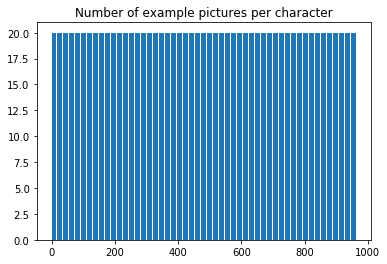

The total number of different pictures is 19280


In [6]:
alph_num_char_ex={}
for alphabet in alph_type:
    char_list=os.listdir(f'{PATH}{alphabet}')
    for char in char_list:
        alph_num_char_ex[(alphabet,char)]= len(os.listdir(f'{PATH}{alphabet}/{char}'))

num_of_example = alph_num_char_ex.values()

plt.bar(range(len(alph_num_char_ex)),num_of_example)
plt.title('Number of example pictures per character')
plt.show()

total_example = sum(num_of_example) 
print(f'The total number of different pictures is {total_example}')

We can observe that each character have 20 examples(pictures) and that our training set is well balanced. For our training we will consider that each character is an independent class.

### Add label for each character


For each picture in our dataset we give a corresponding label(an integer) which allow us to determine the corresponding character. Here an integer is sufficient as we are not really interested in knowing from which alphabet an image is coming from and as we don't have need to know the character name.

##### Train set

In [7]:
Y_train = np.array([i//20+1 for i in range(total_example)])
Y_train.shape

(19280,)

We reshape, our data to have the number of channel including (here is 1).

In [8]:
Y_train=Y_train.reshape(*Y_train.shape,1)
Y_train.shape

(19280, 1)

### Convert images to datafile

We first retrieve the path for each picture in the dataset.

In [9]:
#Train set
imagePath = glob.glob(f"{PATH}*/*/*.png")

#Test set
testPath = glob.glob(f"{PATH_TEST}*/*/*.png")

imagePath[0:5]

['images_background\\Alphabet_of_the_Magi\\character01\\0709_01.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_02.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_03.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_04.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_05.png']

We print some random images of the dataset, convert them to arrays and resize them.

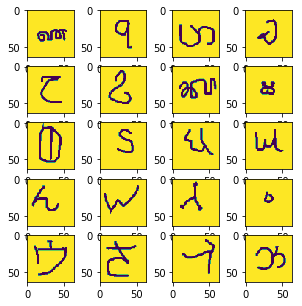

In [31]:
SZ=64 #Dimension of the output image expected

#Dimensions of the grill of sample pictures
columns = 4
rows = 5

fig=plt.figure(figsize=(5, 5))

#Print 20 random examples of images
list_example = np.random.randint(total_example, size = columns*rows)
pos=0
for i in list_example:
    pos+=1
    img = mpimg.imread(imagePath[i])
    img = resize(img, (SZ,SZ), mode='reflect')
    fig.add_subplot(rows, columns, pos)
    plt.imshow(img)
plt.show()

All images seems clear and well centered.

### Image conversion

We convert all images into arrays and resize them to the 60x60 format. We concatenate all arrays into the variable im_array

In [32]:
#Train set
#Transform in array and resize all 19280 images 
X_train = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='reflect') for i in imagePath] )
X_train.shape

(19280, 64, 64)

We reshape the image to take into account the number of channel to pass them in our CNN, which is 1 here.

In [33]:
channel_sz = 1 #number of channel
X_train= X_train.reshape(*X_train.shape, channel_sz)
X_train.shape

(19280, 64, 64, 1)

In [34]:
#Test set
test_array = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='reflect') for i in testPath] )
test_array= test_array.reshape(*test_array.shape, channel_sz)
test_array.shape

(13180, 64, 64, 1)

In [35]:
class_char_test = np.array([i//20+1 for i in range(test_array.shape[0])])
class_char_test = class_char_test.reshape(*class_char_test.shape,1)
class_char_test.shape

(13180, 1)

### Split Train/ validation


We split the traning set into Train and Validation sets of pictures (Train : 70%, Validation : 30%)

In [15]:
#X_train, X_valid, Y_train, Y_valid = train_test_split(im_array, class_char, test_size=0.3, stratify= class_char)

In [16]:
#X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

In [36]:
X_val, X_test, Y_val, Y_test = train_test_split(test_array, class_char_test, test_size=0.7, stratify= class_char_test)
X_val.shape, X_test.shape, Y_val.shape, Y_test.shape

((3954, 64, 64, 1), (9226, 64, 64, 1), (3954, 1), (9226, 1))

### Triplet loss function

Our loss function is determined by the following triplet loss function

In [18]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:196]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1))
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1))
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(basic_loss,0))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))/ alpha * 100 #/ (num_positive_triplets + 1e-16)
    
    return loss

In [19]:
def triplet_loss_np(y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0:64], y_pred[64:128], y_pred[128:196]
    positive_distance = np.square(anchor - positive)
    negative_distance = np.square(anchor - negative)
   
    positive_distance = np.sqrt(np.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = np.sqrt(np.sum(negative_distance, axis=-1, keepdims=True))
   
    basic_loss = alpha + (positive_distance - negative_distance)
    return basic_loss[0]

In [20]:
def triplet_acc(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:196]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    hard_triplets = tf.to_float(tf.greater(basic_loss,alpha))
    num_hard_triplets = tf.reduce_sum(hard_triplets)
    #Count number of triplets
    all_triplets = tf.reduce_sum(tf.to_float(tf.greater(basic_loss,-10**10)))
    
    #Accuracy
    acc = 1 - num_hard_triplets/all_triplets
    
    return acc

##### Triplet Creation

In [21]:
def create_triplets(X, Y, num=1):
    """
    Create a list of valid triplets
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    num -- number of negative images for each valid anchor and positive images - must be positive
           if num = 0, all possible valid couples are created
            For example : for one valid (A,P) couple we can select 'num' random N images. 
                          Thus 'num' triplets are created for this (A,P) couple

    
    Returns:
    (A,P,N) -- python tuple containing 3 arrays : 
            A -- the array for the anchor images, of shape (None, 64)
            P -- the array for the positive images, of shape (None, 64)
            N -- the array for the negative images, of shape (None, 64)
    """

    Y = Y.reshape(Y.shape[0],)
    A = []
    P = []
    N = []
    
    #We loop over all possible valid (A,P)
    for i in range(X.shape[0]):  
        list_pos = X[Y==Y[i]]
        for j in list_pos:
            #We provide a number 'num' of triplets for each valid (A,P)
            if num >=1:
                for k in range(num):
                    rand_num = np.random.randint(X.shape[0])
                    if np.array_equal(X[i],j) == False:
                        A.append(X[i])
                        P.append(j)
                        while np.array_equal(Y[rand_num], Y[i]):
                            rand_num = np.random.randint(X.shape[0])
                        N.append(X[rand_num])
            if num == 0:
                for k in range(X.shape[0]):
                    if np.array_equal(X[i],j) == False:
                        if np.array_equal(Y[i],Y[k]) == False:
                            A.append(X[i])
                            P.append(j)
                            N.append(X[k])
    
    A = np.array(A)
    P = np.array(P)
    N = np.array(N)
    
    return (A, P, N)

In [22]:
#We create one triplet for each of the possible (A,P) couple in our validation set 
"""triplets_list_valid = create_triplets(X_valid,Y_valid)
for i in range(len(triplets_list_valid)):
    print(triplets_list_valid[i].shape)"""

'triplets_list_valid = create_triplets(X_valid,Y_valid)\nfor i in range(len(triplets_list_valid)):\n    print(triplets_list_valid[i].shape)'

In [37]:
triplets_list_val = create_triplets(X_val, Y_val)
print([i.shape for i in triplets_list_val])

[(19770, 64, 64, 1), (19770, 64, 64, 1), (19770, 64, 64, 1)]


This gives us a number of 28920 examples for the validation. Thus 1 negative image per (A,P) couple is enough for our evaluation set.

### Model creation

In [24]:
def EmbModel(input_shape, conv_drop=0, dense_drop=1/32):
    """
    Define our shared embedding model
    
    Arguments:
    input_shape -- shape of array of input images
    conv_drop -- dropout rate for CNN layers
    dense_drop -- dropout rate for Dense layer

    
    Returns:
    model - Our model which transform an array of images into an array of embeddings
    """
    
    
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    
    #CONV
    X = Conv2D(64,(3,3),strides =(1,1), name ='conv0', padding='same', kernel_initializer='glorot_uniform') (X_input)
    X = BatchNormalization(axis = 1, name = "bn0") (X)
    X = Activation('relu', name='a0')(X)
    X = Conv2D(64,(3,3),strides =(1,1), name ='conv0b',padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn0b") (X)
    X = Activation('relu', name='a0b')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool0')(X)
    #X = Conv2D(16,(2,2), strides=(2,2), name='max_pool0')(X)
    
    X = Dropout(conv_drop)(X)
    
    
     #CONV
    Y = X
    X = Conv2D(128,(3,3),strides =(1,1), name ='conv1', padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn1") (X)
    X = Activation('relu', name='a1')(X)
    X = Conv2D(128,(3,3),strides =(1,1), name ='convb1', padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn1b") (X)
    X = Activation('relu', name='a1b')(X)
    
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool1')(X)
    #X = Conv2D(32,(2,2), strides=(2,2), name='max_pool1')(X)
    
    X = Dropout(conv_drop)(X)
    
    
    
     #CONV
    X = Conv2D(128,(3,3),strides =(1,1), name ='conv2', padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn2") (X)
    X = Activation('relu', name='a2')(X)
    X = Conv2D(128,(3,3),strides =(1,1), name ='conv2b', padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn2b") (X)
    X = Activation('relu', name='a2b')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    #X = Conv2D(64,(2,2), strides=(2,2), name='max_pool2')(X)
    
    X = Dropout(conv_drop)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(256,(3,3),strides =(1,1), name ='conv3', padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn3") (X)
    X = Activation('relu', name='a3')(X)
    X = Conv2D(256,(3,3),strides =(1,1), name ='conv3b', padding='same', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn3b") (X)
    X = Activation('relu', name='a3b')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    #X = Conv2D(128,(2,2), strides=(2,2), name='max_pool3')(X)
    
    #X = Dropout(0.2)(X)
    
    #FLATTEN X + FC
    X = Flatten(name='f3')(X)
    #X = Dense (256, activation ='relu', name='fc4', kernel_initializer='glorot_uniform') (X)
    X = Dropout(dense_drop)(X)
    X = Dense (64, activation ='tanh', name='fc5', kernel_initializer='glorot_uniform') (X)
    #X = Lambda(lambda  x: tf.nn.l2_normalize(x,axis=1))(X)
    
    ##Create model
    model = Model(inputs = X_input, outputs = X, name='EmbModel')
    
    return model

In [38]:
from keras import backend as K
    
def EmbModel(input_shape, l2):
    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    kwargs = {'padding':'same', 'kernel_regularizer':regul,'kernel_initializer':'he_normal'}

    inp = Input(input_shape) # 64x64x1
    x   = Conv2D(32, (3,3), strides=1, **kwargs)(inp) #32x32x64
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    #Stage 0 / resblock 0
    y   = Conv2D(32, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(32, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(64, (1,1), strides=1, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 0 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(32, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(32, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 1 / resblock 0
    y   = Conv2D(64, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(128, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 1 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 2 / resblock 0
    y   = Conv2D(128, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(256, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 2 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 3 / resblock 0
    y   = Conv2D(256, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(512, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(512, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 2 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(512, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Final
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = AveragePooling2D(pool_size=8)(x)
    x   = Flatten()(x)
   
    #x = Dropout(1/32)(x)
    
    x = Dense (64, activation ='tanh',kernel_initializer='he_normal') (x)

    
    ##Create model
    model = Model(inputs = inp, outputs = x, name='EmbModel')
    
    return model

#### Global model

In [39]:
#We define our global model
def global_model(size, channel_size=1, l2=1e-4):
    input_size = (size, size, channel_sz)                     

    A = Input(input_size)
    P = Input(input_size)
    N = Input(input_size)

    emb_model= EmbModel(input_size, l2)

    out_A = emb_model(A)
    out_P = emb_model(P)
    out_N = emb_model(N)

    y_pred = concatenate([out_A, out_P, out_N], axis =-1)

    full_model = Model(inputs = [A, P, N], outputs = y_pred)
    
    return full_model, emb_model

In [40]:
def model_fit(model, b_size = 32, ep = 50):

    A,P,N = triplets_list_train
    A_test, P_test, N_test = triplets_list_test
    zeros_vect = np.zeros(A[:,1,1].shape)
    zeros_vect_test = np.zeros(A_test[:,1,1].shape) 
    class_model.fit(x = [A, P, N] , 
                             y = zeros_vect , 
                             batch_size = b_size, 
                             epochs = ep,
                             validation_data = ([A_test, P_test, N_test], zeros_vect_test), 
                             shuffle = True)
    return class_model

In [41]:
classification_model, emb_model = global_model(SZ,channel_sz, l2=1e-3)

In [42]:
classification_model.summary()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
EmbModel (Model)                (None, 64)           2401728     input_9[0][0]                    
                                                                 input_10[0][0]                   
          

## Batch Generator

In [43]:
from keras.preprocessing.image import random_rotation, random_shift, random_shear, random_zoom

def augmentation_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.85, 1.15), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shift(img_arr, wrg=0.15, hrg=0.15,fill_mode='nearest')
    return img_arr

In [44]:
def batch_generator(X,Y, bs=32,hardmode = False):
    """
    Create a mini-batch generator
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    bs -- size of the minibatch

    
    Returns:
    [A_batch, P_batch, N_batch], y_dummie) -- a mini-batch of size bs
    """
    
    Y = Y.reshape(Y.shape[0],)
    while True:
        #0. Initialize Anchor,Postive, Negative
        A_batch = []
        P_batch = []
        N_batch = []
        for i in range(bs) :
            triplet=0
            while triplet>=0 and triplet <10:
                #1.Choose a random Anchor Image
                rand_A_num = np.random.randint(X.shape[0])
                

                #2.Choose a random Positive Image
                list_pos = X[Y==Y[rand_A_num]]                            #List of positive images
                rand_P_num = np.random.randint(len(list_pos))
                while np.array_equal(X[rand_A_num],list_pos[rand_P_num]):
                    rand_P_num = np.random.randint(len(list_pos))
                

                #3.Choose a random Negative Image
                rand_N_num = np.random.randint(X.shape[0])
                while np.array_equal(Y[rand_N_num], Y[rand_A_num]):
                    rand_A_num = np.random.randint(X.shape[0])
                
                loss = -1
                if hardmode==True : 
                    A_augment = augmentation_pipeline(X[rand_A_num])
                    P_augment = augmentation_pipeline(list_pos[rand_P_num])
                    N_augment = augmentation_pipeline(X[rand_N_num])
                    
                    triplet_array = np.array([A_augment, P_augment, N_augment])
                    triplet_emb = emb_model.predict(triplet_array)
                    triplet_emb = np.reshape(triplet_emb, 192)  #3 * 64
                    loss = triplet_loss_np(triplet_emb)
                
                if loss>=0 or hardmode==False:   #0.2 is alpha here
                    if hardmode==False:
                        A_augment = augmentation_pipeline(X[rand_A_num])
                        P_augment = augmentation_pipeline(list_pos[rand_P_num])
                        N_augment = augmentation_pipeline(X[rand_N_num])
                    
                    triplet=-1
                    A_batch.append(A_augment)
                    P_batch.append(P_augment)
                    N_batch.append(N_augment)
            
        A_batch = np.array(A_batch)
        P_batch = np.array(P_batch)
        N_batch = np.array(N_batch)
        
        y_dummie = np.zeros((len(A_batch),))
        
        yield ([A_batch, P_batch, N_batch], y_dummie)

## Real shit

### Checkpoint and early stop

In [ ]:
#Full network 1/32 - Embeddings 64 - Maxout
A_val, P_val, N_val = triplets_list_val
zeros_vect_val = np.zeros(A_val[:,1,1].shape) 


batch_sz = 8


for num in range(1, 10):
    model_name = 'TANH32-%01d.h5' % num
    print(model_name)
    
    #We create a checkpoint to save the best model and add an early stopping
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    lr_annealing = ReduceLROnPlateau(monitor='val_loss', patience = 3, epsilon=0.01, factor = 0.25, min_lr = 0.000001, verbose = 1, mode='min' )
    callbacks_list = [checkpoint, early_stop, lr_annealing]
    

    #We compile our model with the custom made triplet_loss
    classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])
    
    classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz, hardmode=False), 
                                   steps_per_epoch = 550,
                                   epochs = 200,
                                   verbose = 1,
                                   validation_data = ([A_val, P_val, N_val], zeros_vect_val),
                                   callbacks = callbacks_list,
                                  )

TANH32-1.h5
Epoch 1/200
549/550 [============================>.] - ETA: 0s - loss: 400.6861 - triplet_acc: 0.8185

In [39]:
global_loss=1000
A_val, P_val, N_val = triplets_list_val
zeros_vect_val = np.zeros(A_val[:,1,1].shape) 

for weights in ['tanh-1.h5','tanh-2.h5','tanh-3.h5','tanh-4.h5','tanh-5.h5','tanh-6.h5','tanh-7.h5','tanh-8.h5','tanh-9.h5']:
    classification_model.load_weights(weights)
    loss, acc = classification_model.evaluate([A_val, P_val, N_val], zeros_vect_val, batch_size=32, verbose=1)
    if (loss<global_loss):
        model_name = weights
        global_loss = loss
        
classification_model.load_weights(model_name)
model_name, global_loss

19770/19770 [==============================] - 41s 2ms/step


('tanh-7.h5', 77.35597676492786)

In [62]:
classification_model.load_weights('tanh-9.h5')

In [55]:
classification_model.evaluate_generator(batch_generator(X_test, Y_test, batch_sz),steps=550)

[105.84354501637546, 0.9885795454545454]

In [57]:
for weights in ['tanh-1.h5','tanh-2.h5','tanh-3.h5','tanh-4.h5','tanh-5.h5','tanh-6.h5','tanh-7.h5','tanh-8.h5','tanh-9.h5']:
    classification_model.load_weights(weights)
    loss, acc = classification_model.evaluate_generator(batch_generator(X_test, Y_test, batch_sz),steps=550)
    print(weights, loss, acc)
    if (loss<global_loss):
        model_name = weights
        global_loss = loss
        
classification_model.load_weights(model_name)
model_name, global_loss

tanh-1.h5 182.0325780003721 0.9806818181818182
tanh-2.h5 148.22025807120582 0.9832954545454545
tanh-3.h5 125.30392979676073 0.9870454545454546
tanh-4.h5 141.09272041645917 0.9840340909090909
tanh-5.h5 119.49919689752839 0.9871590909090909
tanh-6.h5 125.91501070802862 0.98625
tanh-7.h5 113.52945247476751 0.9879545454545454
tanh-8.h5 106.35614285718312 0.9889772727272728
tanh-9.h5 115.49163587429307 0.9869318181818182


('tanh-7.h5', 77.35597676492786)

#### without dropout batch normalization

In [77]:
class2, emb2 = global_model(SZ,channel_sz, conv_drop = 0, dense_drop = 0)

In [84]:
class2.load_weights(model_name)

In [81]:
class2.summary(), emb2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
EmbModel (Model)                (None, 64)           217680      input_9[0][0]                    
                                                                 input_10[0][0]                   
          

(None, None)

In [85]:
class2.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])
class2.evaluate([A_val, P_val, N_val], zeros_vect_val, batch_size=32, verbose=1)

19770/19770 [==============================] - 41s 2ms/step


[85.74190055845239, 0.9915022761760243]

In [86]:
for layer in class2.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False
class2.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])
class2.fit_generator(batch_generator(X_train, Y_train, batch_sz, hardmode=False), 
                                   steps_per_epoch = 550,
                                   epochs = 10,
                                   verbose = 1,
                                   validation_data = ([A_val, P_val, N_val], zeros_vect_val),
                                   callbacks = callbacks_list
                                  )

for layer in class2.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
class2.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])
class2.save('final.model')

Epoch 1/10
550/550 [==============================] - 153s 278ms/step - loss: 27.9376 - triplet_acc: 0.9970 - val_loss: 85.7419 - val_triplet_acc: 0.9915

Epoch 00001: val_loss improved from 88.47650 to 85.74190, saving model to hard.h5
Epoch 2/10
550/550 [==============================] - 155s 282ms/step - loss: 28.3022 - triplet_acc: 0.9976 - val_loss: 85.7419 - val_triplet_acc: 0.9915

Epoch 00002: val_loss did not improve
Epoch 3/10
173/550 [========>.....................] - ETA: 1:20 - loss: 30.0327 - triplet_acc: 0.9967

KeyboardInterrupt: 

#### Final Model Ensemble

In [44]:
def final_emb(emb_model, item):
    classification_model.load_weights('tanh-7.h5')
    emb1 = emb_model.predict_on_batch(item)
    
    classification_model.load_weights('tanh-8.h5')
    emb2 = emb_model.predict_on_batch(item)
    
    classification_model.load_weights('tanh-9.h5')
    emb3 = emb_model.predict_on_batch(item)
    
    emb = np.mean([emb1,emb2,emb3],axis = 0)
    
    return emb

### Return

Comparison with Modified Hausdorff Distance

In [40]:
from demo_classification import *

In [63]:
def CNNDistance(itemA, itemB):
    itemA = itemA.reshape(1, itemA.shape[0], itemA.shape[1], 1)
    itemB = itemB.reshape(1, itemB.shape[0], itemB.shape[1], 1)
    itemA_emb = emb_model.predict_on_batch(itemA)
    itemB_emb = emb_model.predict_on_batch(itemB)
    dist = np.linalg.norm(itemA_emb - itemB_emb) #2-norm by default
    return dist

In [64]:
def LoadImgAsArray(fn):
	# Load image file, return as array and resize
    picture = mpimg.imread(fn)
    image = resize(picture, (SZ,SZ), mode='constant')
    return image

In [65]:
print ('One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Siamese_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Siamese_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Siamese_triplet_loss_Distance (error 20.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Siamese_triplet_loss_Distance (error 0.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Siamese_triplet_loss_Distance (error 25.0%)
 run 11 ModHausdo

In [45]:
def CNNDistance(itemA, itemB):
    itemA = itemA.reshape(1, itemA.shape[0], itemA.shape[1], 1)
    itemB = itemB.reshape(1, itemB.shape[0], itemB.shape[1], 1)
    itemA_emb = final_emb(emb_model, itemA)
    itemB_emb = final_emb(emb_model, itemB)
    dist = np.linalg.norm(itemA_emb - itemB_emb) #2-norm by default
    return dist

In [46]:
print ('One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Siamese_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Siamese_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 25.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 30.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Siamese_triplet_loss_Distance (error 15.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Siamese_triplet_loss_Distance (error 5.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Siamese_triplet_loss_Distance (error 10.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Siamese_triplet_loss_Distance (error 35.0%)
 run 11 ModHausdo

In [33]:
test_array= test_array.reshape(test_array.shape[0],test_array.shape[1],test_array.shape[2],channel_sz)
print(test_array.shape)

(13180, 60, 60, 1)


In [34]:
class_char_test=np.array([])
for i in range(13180//20):
    #As each character have 20 examples
    class_char_test= np.concatenate((class_char_test, np.ones(20)*(i+1))) 
class_char_test = class_char_test.astype(int)
print(class_char_test.shape)

(13180,)


In [35]:
class_char_test=class_char_test.reshape(class_char_test.shape[0],1)
print(class_char_test.shape)

(13180, 1)


In [37]:
X_test, X_eval, Y_test, Y_eval = train_test_split(test_array, class_char_test, test_size=0.7, stratify= class_char_test)

In [46]:
triplets_list_eval = create_triplets(X_eval, Y_eval)

In [47]:
A_eval, P_eval, N_eval = triplets_list_eval
zeros_vect_eval = np.zeros(A_eval[:,1,1].shape) 

classification_model.evaluate([A_eval, P_eval, N_eval], zeros_vect_eval, verbose=1)



119938/119938 [==============================] - 145s 1ms/step


2.8782454858518958